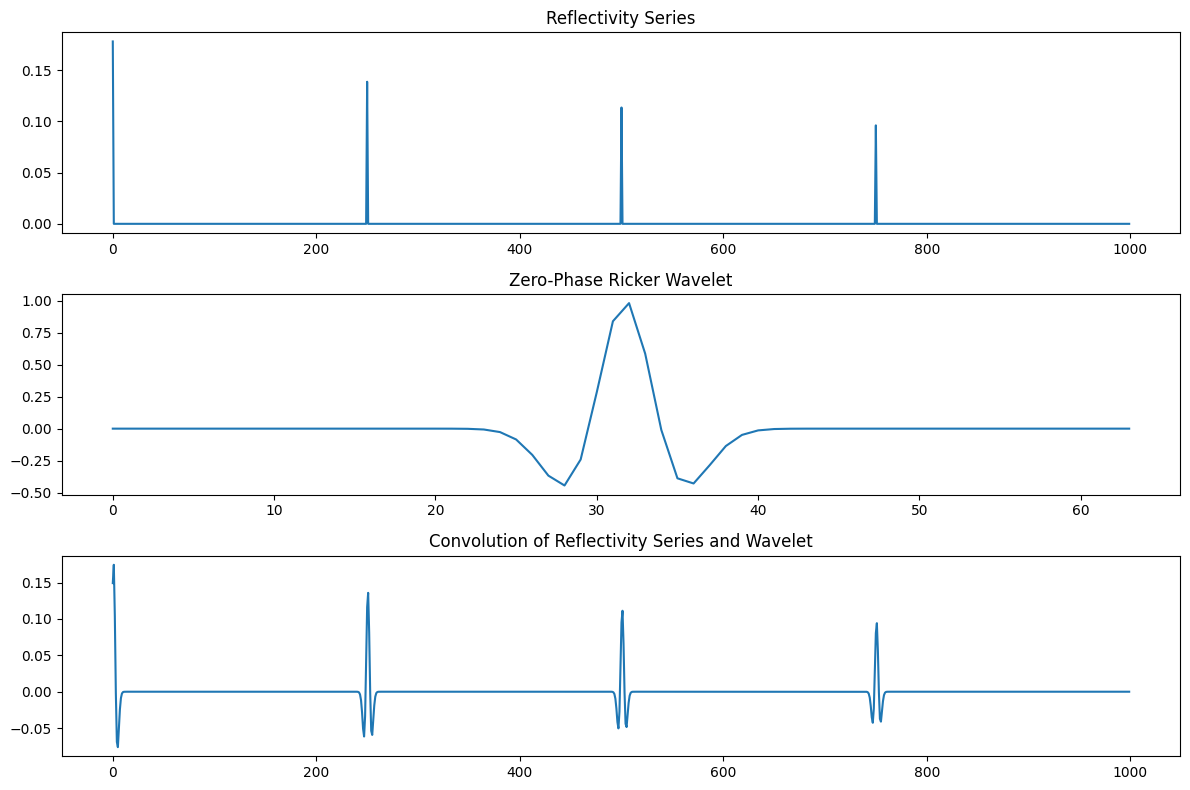

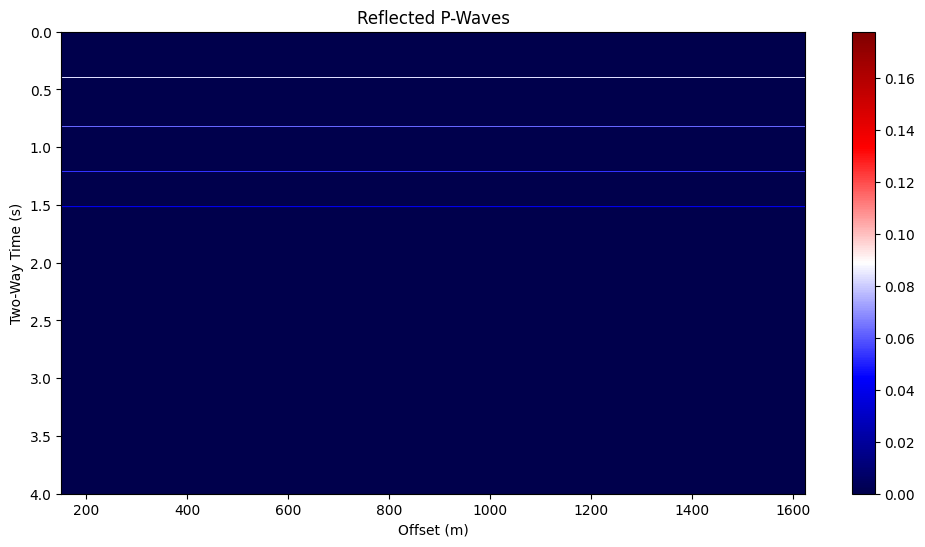

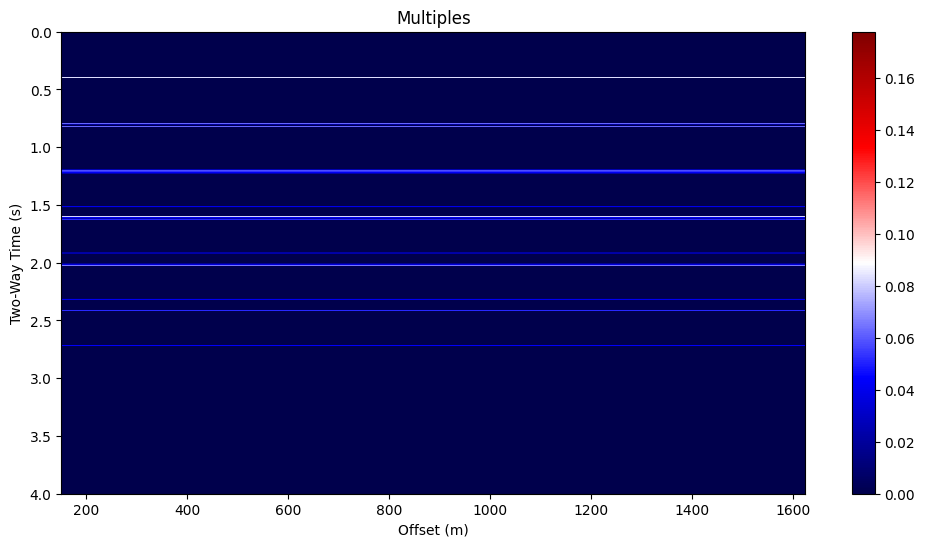

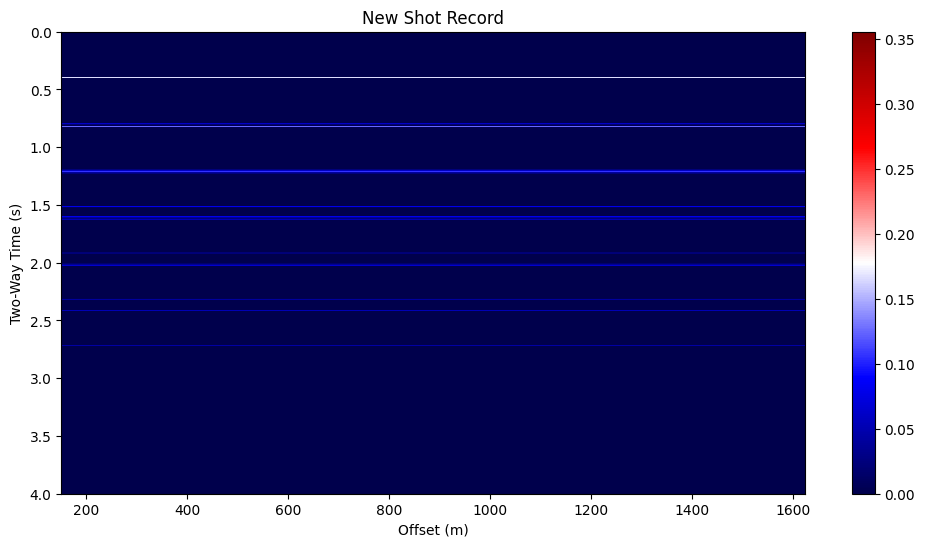

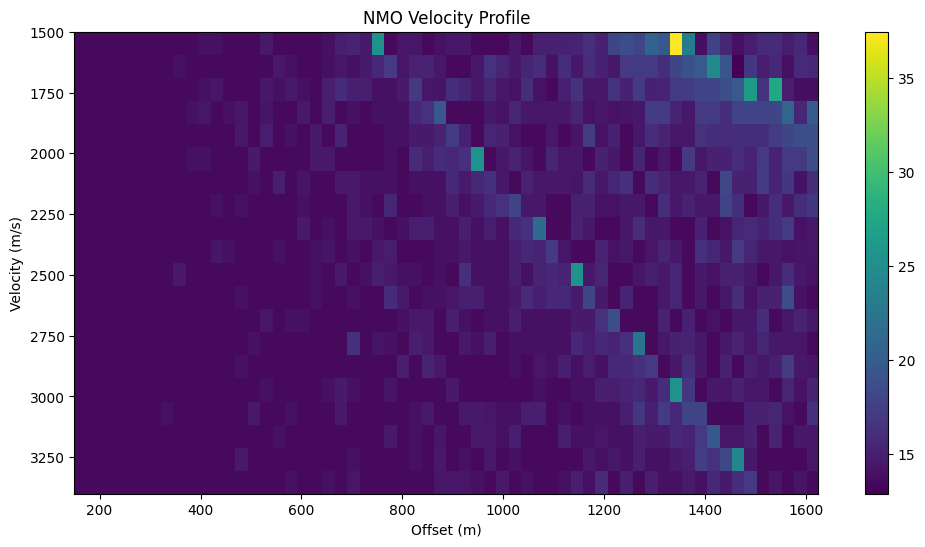

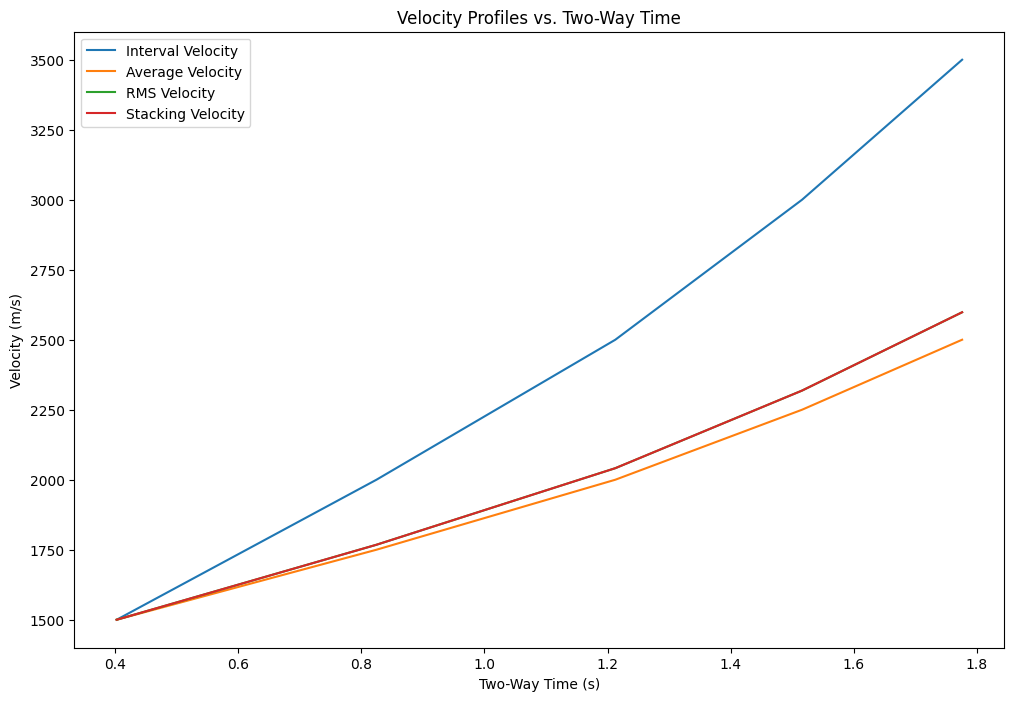

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Define the Earth Model
layers = 5
thickness = np.random.randint(300, 500, size=layers)  # Thickness of each layer in meters
velocities = np.linspace(1500, 3500, layers)  # Increasing velocities in m/s
densities = 0.31 * velocities**0.25  # Gardner's relation

# Calculate Impedance and Reflectivity
impedance = velocities * densities
reflectivity = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])

# Generate a Zero-Phase Ricker Wavelet
def ricker(f, length, dt):
    length = int(length / dt)  # Convert length to number of samples
    t = np.linspace(-length / 2, (length - 1) / 2, length) * dt
    y = (1.0 - 2.0 * (np.pi**2) * (f**2) * (t**2)) * np.exp(-(np.pi**2) * (f**2) * (t**2))
    return y

dt = 0.004  # Sampling interval in seconds
wavelet = ricker(25, 0.256, dt)  # 25 Hz Ricker wavelet

# Convolve Reflectivity Series with Wavelet
reflectivity_series = np.zeros(1000)
reflectivity_series[::250] = reflectivity  # Adjust step size to match the number of reflectivity values
convolved = convolve(reflectivity_series, wavelet, mode='same')

# Plot Reflectivity Series, Wavelet, and Convolution
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(reflectivity_series)
plt.title('Reflectivity Series')
plt.subplot(3, 1, 2)
plt.plot(wavelet)
plt.title('Zero-Phase Ricker Wavelet')
plt.subplot(3, 1, 3)
plt.plot(convolved)
plt.title('Convolution of Reflectivity Series and Wavelet')
plt.tight_layout()
plt.show()

# Generate Synthetic Seismograms for Split Spread Survey
stations = 60
near_offset = 150
trace_interval = 25
offsets = np.arange(near_offset, near_offset + stations * trace_interval, trace_interval)
seismograms = np.zeros((1000, stations))

for i, offset in enumerate(offsets):
    travel_times = 2 * np.cumsum(thickness / velocities)
    for j, t in enumerate(travel_times):
        if j < len(reflectivity):  # Ensure valid index
            seismograms[int(t / dt), i] = reflectivity[j]

# Plot Reflected P-Waves
plt.figure(figsize=(12, 6))
plt.imshow(seismograms, aspect='auto', cmap='seismic', extent=[offsets[0], offsets[-1], 4, 0])
plt.title('Reflected P-Waves')
plt.xlabel('Offset (m)')
plt.ylabel('Two-Way Time (s)')
plt.colorbar()
plt.show()

# Add Multiples
multiples = seismograms.copy()
for i in range(1, 4):
    multiples += np.roll(seismograms, i * int(travel_times[0] / dt), axis=0)

# Plot Multiples
plt.figure(figsize=(12, 6))
plt.imshow(multiples, aspect='auto', cmap='seismic', extent=[offsets[0], offsets[-1], 4, 0])
plt.title('Multiples')
plt.xlabel('Offset (m)')
plt.ylabel('Two-Way Time (s)')
plt.colorbar()
plt.show()

# Generate New Shot Record
new_shot_record = seismograms + multiples

# Plot New Shot Record
plt.figure(figsize=(12, 6))
plt.imshow(new_shot_record, aspect='auto', cmap='seismic', extent=[offsets[0], offsets[-1], 4, 0])
plt.title('New Shot Record')
plt.xlabel('Offset (m)')
plt.ylabel('Two-Way Time (s)')
plt.colorbar()
plt.show()

# Calculate NMO Velocity Profile
def semblance(data, velocities, dt, dx):
    nmo = np.zeros((len(velocities), data.shape[1]))
    for i, v in enumerate(velocities):
        for j in range(data.shape[1]):
            t0 = np.arange(data.shape[0]) * dt
            t = np.sqrt(t0**2 + (dx * j / v)**2)
            t = (t / dt).astype(int)
            t[t >= data.shape[0]] = data.shape[0] - 1
            nmo[i, j] = np.sum(data[t, j])**2 / np.sum(data[t, j]**2)
    return nmo

velocities_nmo = np.arange(1500, 3500, 100)
nmo_profile = semblance(new_shot_record, velocities_nmo, dt, trace_interval)

# Plot NMO Velocity Profile
plt.figure(figsize=(12, 6))
plt.imshow(nmo_profile, aspect='auto', cmap='viridis', extent=[offsets[0], offsets[-1], velocities_nmo[-1], velocities_nmo[0]])
plt.title('NMO Velocity Profile')
plt.xlabel('Offset (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar()
plt.show()

# Calculate and Plot Velocity Profiles
interval_velocity = velocities
average_velocity = np.cumsum(velocities) / np.arange(1, len(velocities) + 1)
rms_velocity = np.sqrt(np.cumsum(velocities**2) / np.arange(1, len(velocities) + 1))
stacking_velocity = rms_velocity  # Simplified assumption

two_way_time = 2 * np.cumsum(thickness / velocities)

plt.figure(figsize=(12, 8))
plt.plot(two_way_time, interval_velocity, label='Interval Velocity')
plt.plot(two_way_time, average_velocity, label='Average Velocity')
plt.plot(two_way_time, rms_velocity, label='RMS Velocity')
plt.plot(two_way_time, stacking_velocity, label='Stacking Velocity')
plt.title('Velocity Profiles vs. Two-Way Time')
plt.xlabel('Two-Way Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()
